## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [48]:
data = pd.read_csv('data/ab_data_tourist.zip', sep=',')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [49]:
# ваш код здесь
data.info()
#тип  - object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [50]:
# ваш код здесь
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

#сделаем промежуточные таблицы для группировки
data_for_first_date = data.groupby(by='group')['date'].min()
display(data_for_first_date)
#2021-01-02

data_for_last_date = data.groupby(by='group')['date'].max()
display(data_for_last_date)
#2021-01-24


group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns]

group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [51]:
# ваш код здесь

#группируем и используем несколько агрегирующих функций, меняем названия столбцов

data_grouped = data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'users_count',
    'purchase':'purchase_count',
    'price':'purchase_sum'})

#перевел сумму покупок в миллионы
data_grouped['purchase_sum'] = data_grouped['purchase_sum'] / 1000000

data_grouped

# количество посещений: A - 147202 , B - 147276	
# количество покупок: A - 17723 , B - 17514
# сумма покупок в миллионах: A - 11436.26 , B - 1554.10

,group,users_count,purchase_count,purchase_sum
0,A,147202,17723,1436.26
1,B,147276,17514,1554.10


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [52]:
# ваш код здесь

# множество пользователей A и B
data_a = set(data[data['group']=='A']['user_id'])
data_b = set(data[data['group']=='B']['user_id'])

user_intersection = data_a.intersection(data_b)
len(user_intersection)
#1895 пользователей

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [53]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

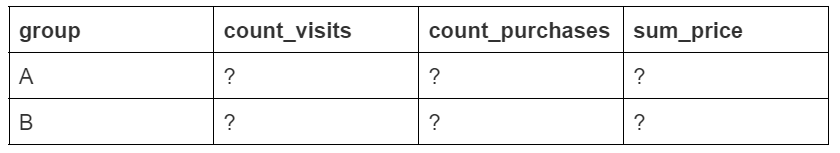
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [54]:
# ваш код здесь
data_updated_grouped = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase':'count_purchase',
    'price':'sum_price'})

data_updated_grouped

,group,count_visits,count_purchase,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

## Выводы
Даже после исключения пользователей, которые есть в обоих группах количество посещений является сопоставимым (145307 - в группе A и 145381 - в группе B). 
Само же количество количество покупок и средний чек такж являются сопоставимыми, что может говорить о том, что были потребители в обеих группах обладают сопоставимым потребительским поведением (заинтересованность в схожих турах, схожей ценовой категории в схожий временной период)

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [55]:
# ваш код здесь
data_updated_grouped['conversion'] = round(data_updated_grouped['count_purchase'] / data_updated_grouped['count_visits'] * 100, 2)
data_updated_grouped['mean_check'] = round(data_updated_grouped['sum_price'] / data_updated_grouped['count_purchase'])

data_updated_grouped

#     conversion   mean_check
#	A	12.03	    81076.0
#	B	11.89	    88665.0

,group,count_visits,count_purchase,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

# Выводы
По показателям конверсии вариант A, лучше варианта B (12.03% против 11.89%), а по среднему чеку - хуже (81076 руб. против 88665 руб.).
По общему результату - сумме покупок - вариант B лучше варианта A (1533 млн. руб. против 1417 млн. руб.)


## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [56]:
# ваш код здесь
data_pivot = updated_data[updated_data['price']!=0].pivot_table(
    values='user_id',
    index='price',
    columns='group',
    aggfunc='count'
)

data_pivot

# количество проданных туров за 60 000 руб.: группа A - 5271, группа B - 1730

group,A,B
price,,
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

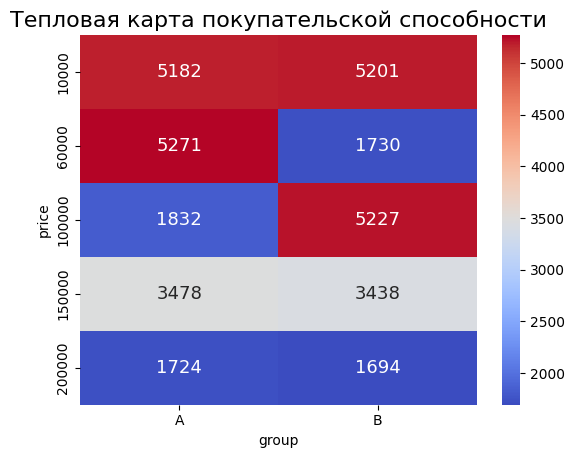

In [57]:
# ваш код здесь
heatmap = sns.heatmap(data=data_pivot, cmap="coolwarm", annot=True , fmt="d", annot_kws={"size":13})
heatmap.set_title('Тепловая карта покупательской способности', fontsize=16);


Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

## Выводы
* По турам стоимостью 200 тыс. руб. (Мальдивы), 150 тыс. руб. (Камчатка), 10 тыс. руб. (Санкт-Петербург) - покупательная способность сопоставима, т.к. количество покупок в группах A и B отличается незначительно. 
* По турам стоимостью 100 тыс. руб. (Таиланд) - больше покупок в группе B, чем в A (5227 против 1832)
* По турам стоимостью 60 тыс. руб. (Турция) - больше покупок в группе A, чем в B (5271 против 1730).
* С учётом этого в среднем покупательная способность в группе B выше и это особенно видно на при сравнении покупок туров за 100 тыс. руб. и за 60 тыс. руб.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [58]:
# ваш код здесь
data_updated_grouped_date = updated_data.groupby(['group','date']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase':'count_purchase',
    'price':'sum_price'})

data_updated_grouped_date['conversion'] = round(data_updated_grouped_date['count_purchase'] / data_updated_grouped_date['count_visits'] * 100, 2)
data_updated_grouped_date['mean_check'] = round(data_updated_grouped_date['sum_price'] / data_updated_grouped_date['count_purchase'])

#ответ на вопросы
data_updated_grouped_date[data_updated_grouped_date['date']=='2021-01-03']

# 	group	date	    count_visits	count_purchase	sum_price	conversion	mean_check
#1	A	    2021-01-03	6596	        748	            62000000	11.34	    82888.0
#24	B	    2021-01-03	6619	        754	            65960000	11.39	    87480.0

,group,date,count_visits,count_purchase,sum_price,conversion,mean_check
1,A,2021-01-03,6596,748,62000000,11.34,82888.0
24,B,2021-01-03,6619,754,65960000,11.39,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [59]:
# ваш код здесь
# вычисляем кумулятивные показатели
data_updated_grouped_date['cum_count_visits'] = data_updated_grouped_date.groupby(['group'])['count_visits'].cumsum()
data_updated_grouped_date['cum_count_purchase'] = data_updated_grouped_date.groupby(['group'])['count_purchase'].cumsum()
data_updated_grouped_date['cum_sum_price'] = data_updated_grouped_date.groupby(['group'])['sum_price'].cumsum()

data_updated_grouped_date['cum_conversion'] = round(data_updated_grouped_date['cum_count_purchase'] / data_updated_grouped_date['cum_count_visits'] * 100, 2)
data_updated_grouped_date['cum_mean_check'] = round(data_updated_grouped_date['cum_sum_price'] / data_updated_grouped_date['cum_count_purchase'])

#ответ на вопросы
display(data_updated_grouped_date[(data_updated_grouped_date['date']=='2021-01-20')&(data_updated_grouped_date['group']=='B')]['cum_conversion'])
# 11.59

display(data_updated_grouped_date[(data_updated_grouped_date['date']=='2021-01-12')&(data_updated_grouped_date['group']=='A')]['cum_mean_check'])
# 11.59

41    11.9
Name: cum_conversion, dtype: float64

10    81492.0
Name: cum_mean_check, dtype: float64

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

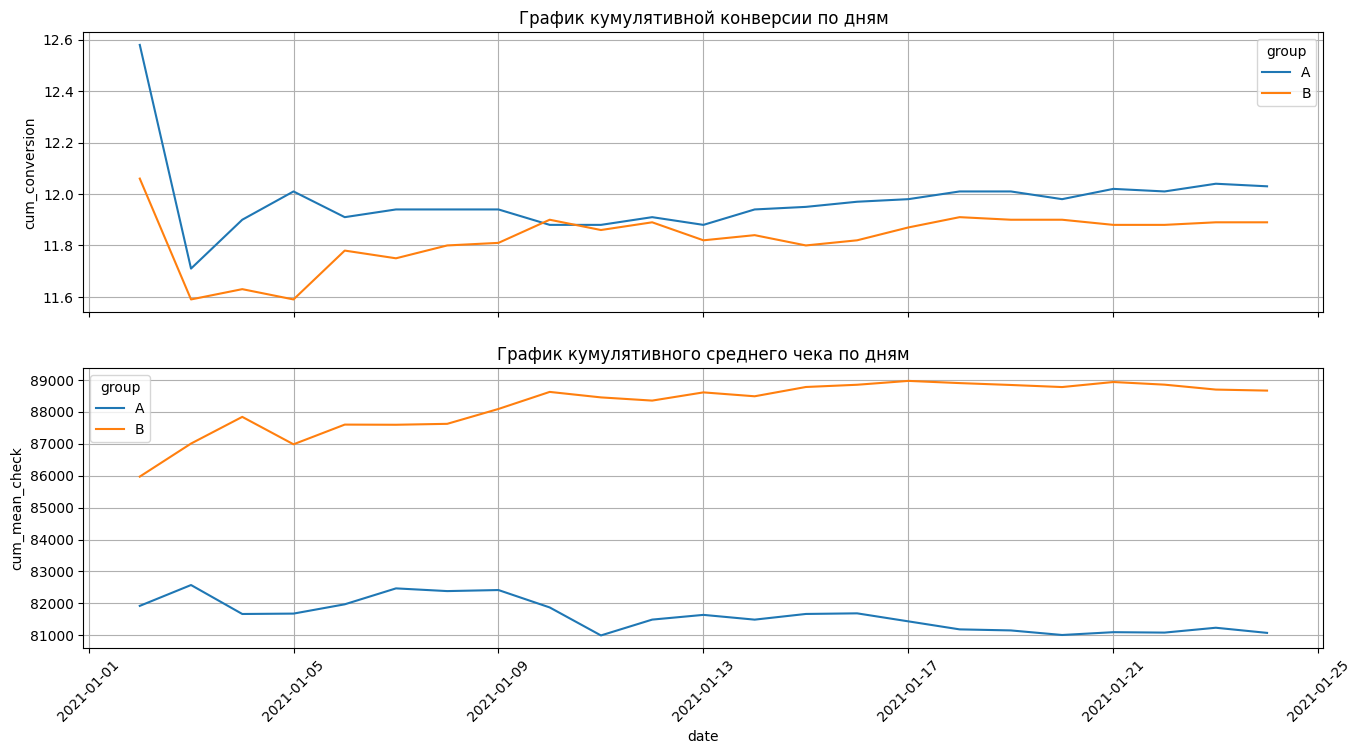

In [60]:
# ваш код здесь

fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,8))

# кумулятивная конверсия
sns.lineplot(x='date', y='cum_conversion', data=data_updated_grouped_date, hue='group', ax=axes[0])
axes[0].set_title('График кумулятивной конверсии по дням')
axes[0].grid(True)

# кумулятивный средний чек
sns.lineplot(x='date', y='cum_mean_check', data=data_updated_grouped_date, hue='group', ax=axes[1])
axes[1].set_title('График кумулятивного среднего чека по дням')
axes[1].xaxis.set_tick_params(rotation = 45)
axes[1].grid(True)


## Выводы
*  A/B-тест можно считать завершенным - кумулятивные метрики стабилизировались: изменения накопленного среднего чека происходят в пределах нескольких сотен рублей, изменения по конверсии -  в пределах нескольких сотых процентов
* Как соотносятся показатели по разным группам: 
1. по коммулятивной конверсии - с середины рассматриваемого временного периода конверсия по группе A устойчиво выше, чем в группе B
2. по коммулятивному среднему чеку - средний чек по группе B выше, чем в группе A на протяжении всего периода

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [61]:
# ваш код здесь
# в первую очередь проверим данные на нормальность распределения

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

alpha = 0.05

_, p = shapiro(data_updated_grouped_date['conversion'])
print('p=%.3f' % p)

# Интерпретация 
if p > alpha:
	print(H0)
else:
	print(Ha)

# p=0.387
# Данные распределены нормально


# т.к. сравниваются только две группы и количество объектов в выборке больше 30, то используем z-тест


# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=data_updated_grouped['count_purchase'], #число "успехов"
    nobs=data_updated_grouped['count_visits'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

# p-value:  0.12
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p=0.387
Данные распределены нормально
p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

## Выводы:
* Данные по конверсии распределены нормально, для проверки гипотезы о равенстве конверсий в группах используем z-тест
* По результатам z-теста, при уровне значимости a=0.05 p-value составило 0.12, что говорит о том, что нулевая гипотеза верна, а значит нет статистической значимости в различиях между конверсиями разных групп. Это косвенно подтверждается на графике кумулятивной конверсии, где видно что по группе А она составляет около 12%, а по группе B - 11.9%

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [62]:
#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']


def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


##Теперь применим нашу функцию к данным группы А и группы B:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))
# Доверительный интервал для конверсии группы А: (11.87, 12.2)
# Доверительный интервал для конверсии группы B: (11.73, 12.06)



#теперь для разности конверсий
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))
#Доверительный интервал для разности конверсий: (-0.38, 0.09)



Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

## Выводы
* С 95% вероятностью: конверсия по группе A находится в диапазоне от 11,87% до 12,2%, конверсия по группе B - в диапазоне от 11,73% до 12,06%
* Есть перекрытие между интервалами по разным группам
* С 95% вероятностью: разница между конверсиями групп находится в диапазоне от -0,38% до 0,09%, т.е. разница может быть как положительной, так и отрицательной, а значит статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [63]:
# ваш код здесь
# проверяем данные на нормальность распределения, используем тест Шапиро-Уилка
# гипотеза "Н0: Распределение нормальное; Н1: Распределение отлично от нормального"

H0 = 'Распределение нормальное'
Ha = 'Распределение отлично от нормального (мы отвергаем H0)'

def test_shapiro(df, alpha = 0.05):
	H0 = 'Распределение нормальное'
	Ha = 'Распределение отлично от нормального (мы отвергаем H0)'
 
	_, p = shapiro(df)
	print('p=%.3f' % p)

	# Интерпретация 
	if p > alpha:
		print(H0)
	else:
		print(Ha)


test_shapiro(data_updated_grouped_date[data_updated_grouped_date['group']=='A']['mean_check'])

# p=0.253
# Распределение нормальное

test_shapiro(data_updated_grouped_date[data_updated_grouped_date['group']=='B']['mean_check'])

# p=0.094
# Распределение нормальное

p=0.253
Распределение нормальное
p=0.094
Распределение нормальное


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [64]:
# ваш код здесь
# т.к. распределение признака нормальное, cравниваются только две группы и количество объектов в выборке не больше 30 (по количеству дней исследования, то используем t-тест

# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=data_updated_grouped_date[data_updated_grouped_date['group']=='A']['mean_check'],
    b=data_updated_grouped_date[data_updated_grouped_date['group']=='B']['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value: 0.0
# Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
# Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

# Выводы:
* по результатам статистического теста: распределение значений среднего ежедневного чека в обеих группах - нормальное
* для дальнейшей проверик гипотезы используем t-тест
* по результатам проверки проверки гипотезы: гипотеза о равенстве средних чеков группе при уровне значимости a=0.05 не подтвердилась, а значит есть статистически значимая разница между средними чеками в разных группах

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ округлите до целого.

In [65]:
# ваш код здесь

def t_conf_interval(df, gamma=0.95):
    n = df.shape[0] # - размер выборки
    k = n - 1 # число степеней свободы
    x_mean = df.mean() # выборочное среднее
    x_std = df.std() # выборочное стандартное отклонение
    alpha = 1 - gamma # уровень значимости

    t_crit = -t.ppf(alpha/2, k) # t-критическое

    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
    print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат
    
t_conf_interval(data_updated_grouped_date[data_updated_grouped_date['group']=='A']['mean_check'])
# Доверительный интервал: (79630, 82308)

t_conf_interval(data_updated_grouped_date[data_updated_grouped_date['group']=='B']['mean_check'])
# Доверительный интервал: (87626, 89526)

Доверительный интервал: (79630, 82308)
Доверительный интервал: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

# Выводы:
* С 95% вероятностью ежедневный средний чек по группе A находится в пределах  от 79630 от 82308 руб.
* С 95% вероятностью ежедневный средний чек по группе B находится в пределах  от 87626 от 89526 руб.
* Интервалы не пересекаются, из чего следует статистически истиннный ежедневный средний чек по группе B будет выше, чем в группе A при заданном уровне надёжности.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

# Выводы:
Т.к. выполняется условие того, что обе выборки после проведения очистки являются сопоставимыми (по объему, по среднему чеку и по покупательскому поведению), то:
* Статистически значемой разницы между показателями конверсии разных групп не существует
* Статистически ежедневный средний чек по группе B выше, чем в группе A.

C учётом этих двух факторов, а также общей суммы покупок (группа A - 1533 млн. руб., группа B - 1417 млн. руб.) рекомендуется использвать вариант B.

Дополнительно следует обратить внимание на то, что в группе B было больше покупок дорогих туров (больше покупок туров за 100 т.р. (Тайланд), меньше туров за 60 тыс. руб.(Турция)). Если это напрямую связано с дизайном страницы (например, больше демонстрировалось изображений из Тайланда, чем из Турции), то это - нормальная ситуация и дополнительно доказывает эффективность дизайна варианта B.

Но не стоит исключать вариант, что это как-то связано с самой выборкой и был упущен какой-то фактор, из-за которого эти выборки перестают быть сопоставимыми. Для этого потребуется дополнительно проанализировать информацию о покупателях этих двух видов туров в обеих группах. 